In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
from pathlib import Path
# Add the project root (one level up from notebooks/) to Python path
sys.path.append(str(Path("../").resolve()))

In [28]:
import pandas as pd 
from src.preprocessing import preprocess_data
from src.train import train_logistic_regression, train_random_forest, train_gradient_boosting
from src.evaluation import compare_models, evaluate_model 
from src.config import DATA_PATH_3

In [29]:
data = pd.read_csv(DATA_PATH_3)

X_train, X_test, y_train, y_test, scaler = preprocess_data(data)

In [30]:
# Train models
lr = train_logistic_regression(X_train, y_train)
rf = train_random_forest(X_train, y_train)
gb = train_gradient_boosting(X_train, y_train)

c:\Users\AGU MICHAEL\Documents\LoanDefaultRiskPrediction\loandefault_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [31]:
models = {
    "Logistic Regression": lr,
    "Random Forest": rf,
    "Gradient Boosting": gb
}

In [32]:
results = compare_models(models, X_test, y_test)


In [33]:
results_df = pd.DataFrame(results).T
results_df

Accuracy    Recall Precision  F1 Score  \
Logistic Regression  0.676875  0.701568   0.22024   0.33524   
Random Forest        0.733386  0.628056  0.246118   0.35365   
Gradient Boosting    0.886724  0.075367  0.597594  0.133852   

                                   Confusion_Matrix   ROC_AUC  
Logistic Regression  [[30407, 14732], [1770, 4161]]  0.753193  
Random Forest        [[33729, 11410], [2206, 3725]]  0.754153  
Gradient Boosting       [[44838, 301], [5484, 447]]  0.759703

In [24]:
results_df.to_csv("model_comparison.csv", index=False)

Gradient Boosting, Random Forest, and Logistic Regression were evaluated on the test set. Logistic Regression was selected as the final model because it achieved the highest Recall (70%), making it the most effective at identifying potential defaulters. Random Forest also performed well, but the main goal of minimizing missed defaults prioritized Recall. Gradient Boosting had higher Precision but lower Recall, resulting in more false negatives, which is less desirable in this context.

In [34]:
# Select best model based on Recall
best_model_name = results_df["Recall"].idxmax()
best_model = models[best_model_name]

print(f"Best Model Based on Recall: {best_model_name}")


Best Model Based on Recall: Logistic Regression


In [35]:
# best model evaluation
evaluate_model(best_model, X_test, y_test)

{'Accuracy': 0.6768748776189544,
 'Recall': 0.7015680323722813,
 'Precision': 0.22024030064044883,
 'F1 Score': 0.3352400902352562,
 'Confusion_Matrix': array([[30407, 14732],
        [ 1770,  4161]]),
 'ROC_AUC': 0.7531926831647832}

Recall: 0.70 crucial for catching actual defaulters (true positives).

Precision: Lower than Recall, indicating some false positives.

F1 Score: Balanced at a moderate level, providing a holistic measure between Recall and Precision.

ROC-AUC: 0.75 indicates reasonable ability to distinguish defaulters from non-defaulters.

Accuracy: Not emphasized due to the imbalanced dataset.


### Interpretation:
Prioritizing Recall ensures fewer defaulters are missed, even if it increases false positives. F1 score confirms a reasonable balance, while ROC-AUC shows the model is generally capable of ranking high-risk loans.

### Confusion Matrix Insights

True Positives (TP): Correctly identified defaulters

False Negatives (FN): Missed defaulters, minimized by high Recall

False Positives (FP): Non-defaulters incorrectly flagged, acceptable trade-off

True Negatives (TN): Correctly identified non-defaulters

This matrix demonstrates that the model effectively prioritizes identifying defaulters, which aligns with the project goal.

In [36]:
coefficients = best_model.coef_[0]

feature_importance = pd.DataFrame({
    "Feature": X_train.columns,
    "Coefficient": coefficients
}).sort_values(by="Coefficient", key=abs, ascending=False)

print(feature_importance.head(10))


                      Feature  Coefficient
0                         Age    -0.582796
6                InterestRate     0.459027
4              MonthsEmployed    -0.338597
1                      Income    -0.333180
2                  LoanAmount     0.325322
13  EmploymentType_Unemployed     0.190248
22            HasCoSigner_Yes    -0.129596
17          HasDependents_Yes    -0.126188
3                 CreditScore    -0.124602
11   EmploymentType_Part-time     0.116660


In [37]:
print(feature_importance.tail(10))

                   Feature  Coefficient
10       Income_Loan_Ratio     0.077558
20        LoanPurpose_Home    -0.074119
8                 DTIRatio     0.055886
18    LoanPurpose_Business     0.025263
15    MaritalStatus_Single    -0.024526
24           High_DTI_True     0.015735
19   LoanPurpose_Education    -0.004343
21       LoanPurpose_Other    -0.003669
23  Stable_Employment_True     0.002384
7                 LoanTerm     0.000841


In [25]:
feature_importance.to_csv("logistic_feature_importance.csv", index=False)

In [38]:
import numpy as np

odds_ratios = np.exp(best_model.coef_[0])
for col, or_val in zip(X_train.columns, odds_ratios):
    print(f"{col}: {or_val:.2f}")


Age: 0.56
Income: 0.72
LoanAmount: 1.38
CreditScore: 0.88
MonthsEmployed: 0.71
NumCreditLines: 1.11
InterestRate: 1.58
LoanTerm: 1.00
DTIRatio: 1.06
Education: 0.92
Income_Loan_Ratio: 1.08
EmploymentType_Part-time: 1.12
EmploymentType_Self-employed: 1.11
EmploymentType_Unemployed: 1.21
MaritalStatus_Married: 0.91
MaritalStatus_Single: 0.98
HasMortgage_Yes: 0.92
HasDependents_Yes: 0.88
LoanPurpose_Business: 1.03
LoanPurpose_Education: 1.00
LoanPurpose_Home: 0.93
LoanPurpose_Other: 1.00
HasCoSigner_Yes: 0.88
Stable_Employment_True: 1.00
High_DTI_True: 1.02


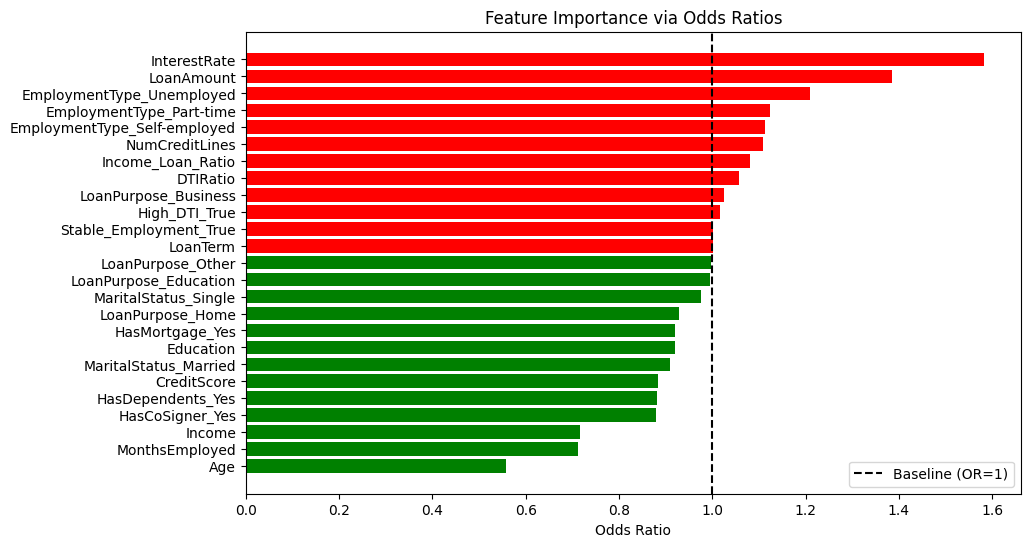

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Compute odds ratios
odds_ratios = np.exp(best_model.coef_[0])

# Map feature names to their odds ratios
feature_or = dict(zip(X_train.columns, odds_ratios))

# Sort features by odds ratio for better visualization
sorted_features = dict(sorted(feature_or.items(), key=lambda x: x[1], reverse=True))

# Create bar chart
plt.figure(figsize=(10,6))
colors = ['green' if v < 1 else 'red' for v in sorted_features.values()]  # <1 reduces odds, >1 increases odds
plt.barh(list(sorted_features.keys()), list(sorted_features.values()), color=colors)
plt.axvline(1, color='black', linestyle='--', label='Baseline (OR=1)')
plt.xlabel("Odds Ratio")
plt.title("Feature Importance via Odds Ratios")
plt.gca().invert_yaxis()  # largest OR on top
plt.legend()
plt.savefig("sorted_features.png", dpi=300, bbox_inches='tight')
plt.show()

Features like Age, Income, MonthsEmployed, InterestRate, LoanAmount, and EmploymentType_Unemployed strongly influenced default prediction and ‘worked’ as expected, while features such as LoanTerm, Stable_Employment_True, and some LoanPurpose categories had minimal impact (‘failed’ to contribute), suggesting that next steps could include focusing on the most predictive features, exploring feature interactions, or simplifying the model to improve interpretability without losing performance.

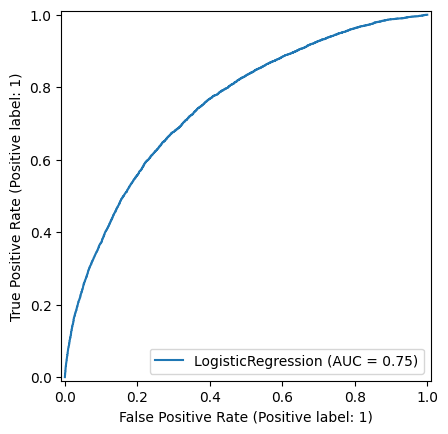

In [48]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(best_model, X_test, y_test)

plt.savefig("RocCurveDisplay.png", dpi=300, bbox_inches='tight')
plt.show()


## MODEL LEARNING CURVE

In [42]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring="recall",  #  Recall is the priority
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean scores
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

# Plot
plt.figure()
plt.plot(train_sizes, train_mean)
plt.plot(train_sizes, val_mean)

plt.xlabel("Training Size")
plt.ylabel("Recall Score")
plt.title("Learning Curve")
plt.legend(["Training Score", "Validation Score"])
plt.show()

The learning curve analysis showed no evidence of significant overfitting, as the training and validation Recall scores converged with increasing sample size, indicating good generalization. Validation curves were further used to tune the regularization strength, selecting the parameter that maximized Recall while preserving stable validation performance.

## **MODEL SAVED**

In [51]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import joblib

# Suppose your current data
# X_train, X_test, y_train, y_test
# and your best_model is LogisticRegression already trained

# Identify numeric & categorical features
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
])

# Build the pipeline with your trained Logistic Regression
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", best_model)   # your current LogisticRegression model
])

# Fit the pipeline on training data (so it “knows” preprocessing)
pipeline.fit(X_train, y_train)

# Save the pipeline
joblib.dump(pipeline, "logistic_pipeline.pkl")
print("Pipeline saved successfully!")


c:\Users\AGU MICHAEL\Documents\LoanDefaultRiskPrediction\loandefault_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


Pipeline saved successfully!


In [ ]:


# Load the pipeline
pipeline = joblib.load("models/logistic_pipeline.pkl")

# New applicant data (columns must match training set)
new_data = pd.DataFrame([
    {"Loan_Amount": 5000, "Income": 45000, "Age": 35, "Has_Cosigner": "No", "marital_status": "Single",
     "CreditScore": 300, "MonthsEmployed": 12,}
])

# Predict
pred_label = pipeline.predict(new_data)         # 0 or 1
pred_prob = pipeline.predict_proba(new_data)[:,1]  # Probability of default

print("Predicted label:", pred_label)
print("Predicted probability:", pred_prob)
